<H1>10,000 USD worth of TKN invested in the Omnipool for one year</H1>

In [185]:
import sys
import os
import glob
import random
sys.path.append('../..')

from model import processing
from matplotlib import pyplot as plt

from model import run
from model import plot_utils as pu
from model.amm.omnipool_amm import OmnipoolState, cash_out_omnipool, usd_price, lrna_price, value_assets
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, price_sensitive_trading
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices, ArchiveState

# same seed, same parameters = same simulation result
random.seed(42)
price_list = processing.import_binance_prices(['BTC', 'ETH', 'DOT'], start_date='Jan 1 2023', days = 30)

assets = {
    'HDX': {'usd price': 0.05, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.20},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.40},
    'DOT': {'usd price': 1, 'weight': 0.1},
    'TKN': {'usd price': 1, 'weight': 0.1}
}

lrna_price_usd = 0.07
initial_omnipool_tvl = 10000000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            asset_fee=0.0025,
            lrna_fee=0,
            withdrawal_fee=False
        )
    },
    agents = {
        'Trader': Agent(
            holdings={tkn: 10000000 for tkn in assets}
        ),
        'LP': Agent(
            holdings={'TKN': 1000000000},
            trade_strategy=invest_all('omnipool')
        ),
        'LP2': Agent(
            holdings={'DOT': 1000000000},
            trade_strategy=invest_all('omnipool')
        )
    },
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    archive_all=False
)
time_steps = 219000  # int(7200 * 365 / 12)

# copy DOT prices for TKN
# for j, step in enumerate(price_list):     
#     step['TKN'] = step['DOT'] / price_list[0]['DOT']

In [193]:
new_state = initial_state.copy()
events = []
time_steps = 1
# omnipool=new_state.pools['omnipool']
# omnipool.protocol_shares['TKN'] = 0
# omnipool.shares['TKN'] = 1000000
# omnipool.liquidity['TKN'] = 1000000
# omnipool.lrna['TKN'] = 1000000
# new_state.agents['LP'].holdings[('omnipool', 'TKN')] = 1000000
# new_state.agents['LP'].holdings['TKN'] = 0
new_state = new_state.agents['LP'].trade_strategy.execute(new_state, 'LP')
new_state = new_state.agents['LP2'].trade_strategy.execute(new_state, 'LP2')
for i in range(time_steps):
    # new_state.execute_swap(
    #     pool_id='omnipool',
    #     agent_id='Trader',
    #     tkn_sell='TKN',
    #     tkn_buy='DOT',
    #     sell_quantity=1 / initial_state.external_market['TKN']
    # )
    new_state.execute_swap(
        pool_id='omnipool',
        agent_id='Trader',
        tkn_sell='DOT',
        tkn_buy='TKN',
        sell_quantity=1 / initial_state.external_market['DOT']
    )
    events.append(new_state.archive())

print (f'initial liquidity: {initial_state.pools["omnipool"].liquidity["TKN"]}')
print (f"TKN trade volume: {sum([event.pools['omnipool'].volume_out['TKN'] for event in events])}")
trade_volume = sum([event.pools['omnipool'].volume_out['TKN'] for event in events]) / initial_state.pools['omnipool'].liquidity['TKN']

print(f'ratio: {trade_volume}')
profit = (
    cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['LP'], events[-1].external_market)
    - cash_out_omnipool(initial_state.pools['omnipool'], initial_state.agents['LP'], initial_state.external_market)
)
profit2 = (
    cash_out_omnipool(events[-1].pools['omnipool'], events[-1].agents['LP2'], events[-1].external_market)
    - cash_out_omnipool(initial_state.pools['omnipool'], initial_state.agents['LP2'], initial_state.external_market)
)
print(f'TKN LP profit: {profit}')
print(f'DOT LP profit: {profit2}')

initial liquidity: 1000000000.0
TKN trade volume: 0.997499942779541
ratio: 9.97499942779541e-10
TKN LP profit: 0.0006250143051147461
DOT LP profit: -1.1920928955078125e-07


In [191]:
new_agent = events[-1].agents['LP']
new_pool = events[-1].pools['omnipool']
print(f"fraction of the pool owned by TKN LP: {new_agent.holdings[('omnipool', 'TKN')] / new_pool.shares['TKN']}")
print(
    f'expected profit by the formula LP shares / pool shares * trade volume * asset fee: '
    f"{1000000 * trade_volume * new_agent.holdings[('omnipool', 'TKN')] / new_pool.shares['TKN'] * 0.0025}"
)
print(f"starting liquidity in TKN: {initial_state.pools['omnipool'].liquidity['TKN']}")
print(f"starting liquidity in DOT: {initial_state.pools['omnipool'].liquidity['DOT']}")

print(f"ending liquidity in TKN after fees: {new_pool.liquidity['TKN']}")
print(f"ending liquidity in DOT after fees: {new_pool.liquidity['DOT']}")


fraction of the pool owned by TKN LP: 0.5
expected profit by the formula LP shares / pool shares * trade volume * asset fee: 1.246874928474426e-06
starting liquidity in TKN: 1000000000.0
starting liquidity in DOT: 1000000000.0
ending liquidity in TKN after fees: 1999999999.0025
ending liquidity in DOT after fees: 2000000001.0


In [188]:
volume_events = []
trade_volume = []
semi_final_state = []
final_state = []
# initial_state._evolve_function = historical_prices(price_list)
for i in range(5):
    initial_state.agents['Trader'].trade_strategy=price_sensitive_trading(
        pool_id='omnipool',
        max_volume_usd=1.77 * i,
        price_sensitivity=10
    ) if i > 0 else None
    events = run.run(initial_state, time_steps)
    
    trade_volume.append({tkn: (sum([event.pools['omnipool'].volume_out[tkn] * event.external_market[tkn] 
                                    / event.pools['omnipool'].liquidity[tkn] for event in events])
        / time_steps * 7200) for tkn in assets}
    )
    print('Trade volume per day as a fraction of TVL:', trade_volume[i])

    volume_events.append(events[::200])
    volume_events[-1].append(events[-1])
    
    del events

Starting simulation...
Execution time: 0.015 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.0, 'USD': 0.0, 'BTC': 0.0, 'ETH': 0.0, 'DOT': 0.0, 'TKN': 0.0}
Starting simulation...
Execution time: 0.017 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.0, 'USD': 0.0, 'BTC': 0.0, 'ETH': 0.0, 'DOT': 0.0, 'TKN': 0.0}
Starting simulation...
Execution time: 0.011 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.0, 'USD': 9.862465001732927e-05, 'BTC': 0.0, 'ETH': 0.0, 'DOT': 0.0, 'TKN': 0.0}
Starting simulation...
Execution time: 0.017 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.0, 'USD': 0.0, 'BTC': 0.0, 'ETH': 0.0, 'DOT': 0.0, 'TKN': 0.0}
Starting simulation...
Execution time: 0.011 seconds.
Trade volume per day as a fraction of TVL: {'HDX': 0.0, 'USD': 0.0, 'BTC': 0.0, 'ETH': 0.0, 'DOT': 0.0, 'TKN': 0.0}


<H3>Effects of trade volume.</H3>
Trade volume generates fees, which are the primary way of offsetting IL. We'll assume the middle price path for this example (minimum impermanent loss). Trade volume goes from 0% to 2% of TVL per day. (So far we have observed ~1% on average.) We also assume 0.3% total fees.

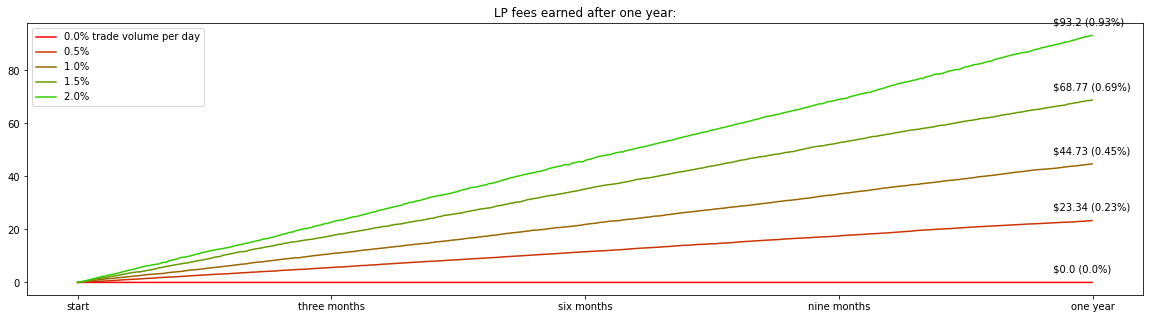

In [92]:
plt.figure(figsize=(20, 5))
plt.title('LP fees earned after one year:')
graph_length = len(volume_events[1])
plt.xticks(
    [0, graph_length / 4, graph_length / 2, graph_length * 3/4, graph_length],
    ['start', 'three months', 'six months', 'nine months', 'one year']
)
colors = pu.color_gradient(length=5, color1=(255, 0, 0), color2=(0, 255, 0))
baseline =[value_assets(event.external_market, initial_state.agents['LP'].holdings) for event in volume_events[0]]
# [0] * len(volume_events[0])
# [cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market) for event in volume_events[0]]
volume_returns = [
    [
        (cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market)
        - baseline[i]) * 12  # extend to one year
        for i, event in enumerate(events)
    ]
    for events in volume_events
]

for i, scenario in enumerate(volume_returns):
    plt.plot(range(len(scenario)), scenario, color=colors[i])
    plt.annotate(
        f'${round(scenario[-1], 2)} ({round(scenario[-1] / 100, 2)}%)', 
        xy=(len(scenario), scenario[-1]), xytext=(-40, 10), textcoords='offset points'
    )
    
plt.legend([
    f'{round(volume["TKN"] * 100, 1)}% {("trade volume per day") if volume["TKN"] == 0 else ""}' 
    for volume in trade_volume
])

In [89]:
print([volume for volume in trade_volume])

[{'HDX': 0.0, 'USD': 0.0, 'BTC': 0.0, 'ETH': 0.0, 'DOT': 0.0, 'TKN': 0.0}, {'HDX': 7.781167040303581e-05, 'USD': 0.0007874260645960589, 'BTC': 26.42436809701106, 'ETH': 0.47268295315498926, 'DOT': 0.004008308302274744, 'TKN': 0.005182438844543454}, {'HDX': 0.00015197539660357818, 'USD': 0.0015605658195686548, 'BTC': 52.247243890517765, 'ETH': 0.931153960261646, 'DOT': 0.007899825509897545, 'TKN': 0.010164664171772645}, {'HDX': 0.00023760101589215407, 'USD': 0.002349502817568508, 'BTC': 77.87382123142041, 'ETH': 1.4057342879284818, 'DOT': 0.011929295807772118, 'TKN': 0.015362114348412843}, {'HDX': 0.0003141001336609083, 'USD': 0.003139637012397347, 'BTC': 103.29873318553224, 'ETH': 1.8969015493669807, 'DOT': 0.01606583919790784, 'TKN': 0.02039165314549087}]


In [87]:
for i in range(len(trade_volume)):
    print(10000 * trade_volume[i]['TKN'] * 0.0025 * 365)
    print(volume_returns[i][-1])


0.0
0.0
47.28975445645902
23.70150128453679
92.75256056742539
46.46027708148176
140.1792934292672
70.25133469186403
186.0738349526042
93.22100632900401


In [35]:
initial_state.pools['omnipool'].liquidity['TKN']

300000.0

In [40]:
print(volume_events[-1][-1].agents['LP'].holdings)

{'TKN': 0, 'HDX': 0, 'USD': 0, 'ETH': 0, 'BTC': 0, 'DOT': 0, ('omnipool', 'TKN'): 10000.0, ('omnipool', 'HDX'): 0.0, ('omnipool', 'USD'): 0.0, ('omnipool', 'ETH'): 0.0, ('omnipool', 'BTC'): 0.0, ('omnipool', 'DOT'): 0.0, 'LRNA': 0}


In [53]:
event = volume_events[4][-1]
print(cash_out_omnipool(event.pools['omnipool'], event.agents['LP'], event.external_market))

10007.432221054403


<AxesSubplot:title={'center':'omnipool  usd_price TKN '}>

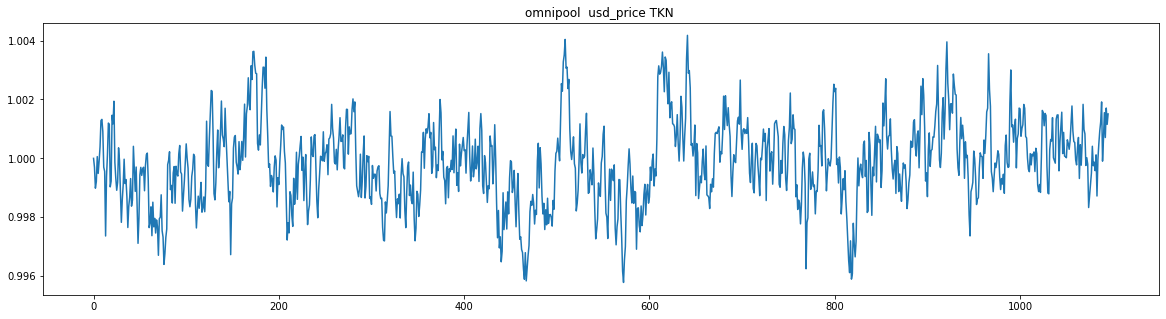

In [81]:
pu.plot(volume_events[4], pool='omnipool', prop='usd_price', key='TKN')

<AxesSubplot:title={'center':'asset price: USD '}>

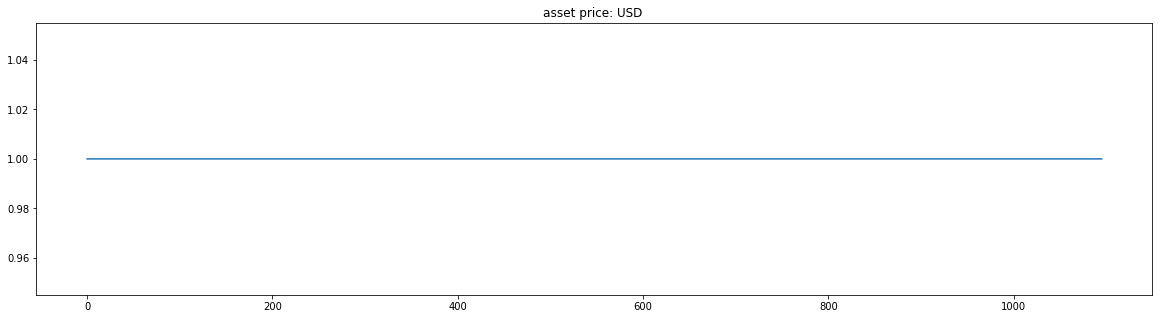

In [95]:
pu.plot(volume_events[4], asset='USD')